In [2]:
from rake_nltk import Rake
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import random
from sklearn.cluster import KMeans,DBSCAN
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import library.utils
import seaborn as sns

def tokenize(text):
    r = Rake()
    r.extract_keywords_from_text(text.lower().replace('nan',' '))
    return r.get_ranked_phrases()[0:10]

### Function to actually recommend similar foods
similarity_thereshold = 0.5
def recommend(name,data,cosine_sim):
    indices = pd.Series(data['name'])
    recommended_items = []
    
    if indices[indices == name].any():
        idx = indices[indices == name].index[0]
        score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
        count = score_series.apply(lambda x : x > similarity_thereshold).sum()
        top_indices = list(score_series.iloc[1 : count+1].index)
        print('Total similar foods count: ', count)

        for i in top_indices:
            recommended_items.append(data.iloc[i]['name'])
        return list(set(recommended_items))
    else:
        print('Oops, Item Not Found :(') 

### Fuction to recommend based on the top order item
def historical_recommend(userid, orders, items, cosine_sim):
    items_order_by_user = orders[orders.userid == userid].name.value_counts()
    top_order_item = items_order_by_user.idxmax()

    item_name = items[items.name == top_order_item].name.values[0]
    item_description = items[items.name == item_name].description.values[0]

    print('Top order food is: ',item_name)
    print('Top order food description is: ',item_description)

    return recommend(item_name,food_items,cosine_sim)    


def match_ingredients(string,ingredients):
    if all(x.lower() in string for x in ingredients):
        return True
    else:
        return False

def ingredient_recommendation(data,ingredients):
    items = data[data['tokens'].apply(lambda x: match_ingredients(x,ingredients))]
    print('Total food item found: {}'.format(items.shape[0]))
    
    for index,row in items.iterrows():
        print('\nitem name: {}\nitem description is: {}'.format(row['name'],row['description']))  

In [2]:
orders = pd.read_csv('../data/full_data.csv',low_memory=False)
orders.head(3)

,OrderId,UserId,RestaurantId,Date,Rating,Comments,Address,Count,ItemId,Price,ViewCount,Name,Description,SearchVector,Type
0,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,211,15.0,0.0,Tableside Spinach Salad,NaN,'almond':8 'babi':4 'bacon':11 'jack':10 'mont...,Main
1,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,218,27.0,0.0,King Crab,NaN,'blanc':9 'buerr':8 'caper':7 'char':3 'chilli...,Main
2,293,4,121,2020-05-13 01:20:59.267256,NaN,NaN,NaN,1,440,14.0,1097.0,Joojeh Kabab With Rice,One skewer of chicken breast marinated with yo...,'bbq':14 'chicken':11 'joojeh':1 'juic':9 'kab...,Main


In [3]:
food_items = pd.read_csv('../data/itemsInfo_full.csv',low_memory=False)
food_items.head()

,Id,Price,ViewCount,Name,Description,TagsString,SearchVector,Type
0,8345,0.9,0,Cookie,Freshly baked cookies. One order comes with on...,NaN,'cooki':1,Main
1,8346,7.0,0,12 Cookies,Freshly baked cookies. One order comes with tw...,NaN,'12':1 'cooki':2,Main
2,2046,18.0,0,Sausage Hash-n-eggs,NaN,NaN,'egg':5 'hash':3 'hash-n-egg':2 'n':4 'sausag':1,Main
3,2047,18.0,0,Ham Hash-n-eggs,NaN,NaN,'egg':5 'ham':1 'hash':3 'hash-n-egg':2 'n':4,Main
4,2048,18.0,0,Debakon Hash-n-eggs,DeBakon with hash-n-eggs.,NaN,'debakon':1 'egg':5 'hash':3 'hash-n-egg':2 'n':4,Main


In [4]:
food_items.columns = [c.lower() for c in food_items.columns]
orders.columns = [c.lower() for c in orders.columns]

In [5]:
food_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68100 entries, 0 to 68099
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            68100 non-null  int64  
 1   price         67938 non-null  float64
 2   viewcount     68100 non-null  int64  
 3   name          68082 non-null  object 
 4   description   48742 non-null  object 
 5   tagsstring    34591 non-null  object 
 6   searchvector  68081 non-null  object 
 7   type          68082 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 4.2+ MB


In [6]:
food_items.description.isna().sum()

19358

In [7]:
#items = items[~items.description.isna()].reset_index(drop=True)

In [8]:
food_items.description

0        Freshly baked cookies. One order comes with on...
1        Freshly baked cookies. One order comes with tw...
2                                                      NaN
3                                                      NaN
4                                DeBakon with hash-n-eggs.
                               ...                        
68095                                                  NaN
68096                                                  NaN
68097    White radish, carrot, mini cucumber, Japanese ...
68098                                                  NaN
68099                                                  NaN
Name: description, Length: 68100, dtype: object

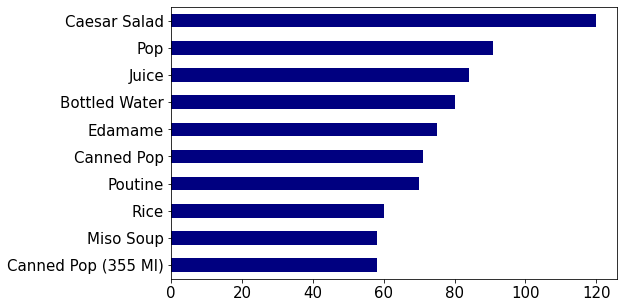

In [9]:
food_items['name'].value_counts()[0:10].plot(kind ='barh', figsize=[8,5], fontsize=15, color='navy').invert_yaxis()


In [10]:
#items = items[~(items.description.duplicated() & items.name)].reset_index(drop=True)

In [11]:
food_items.drop_duplicates(subset = ['name','description'], keep = 'first', inplace = True)
food_items.reset_index(drop=True, inplace=True);

In [12]:
food_items.index

RangeIndex(start=0, stop=49316, step=1)

In [13]:
food_items.columns

Index(['id', 'price', 'viewcount', 'name', 'description', 'tagsstring',
       'searchvector', 'type'],
      dtype='object')

After testing different approaches to get the best result for the simiar foods, we learnt, combining different columns with good information can increase the similarity rate. Therefore we combined the name and description of the food and the results were awesome. Also another reason was, that some resutauarnts did not add a good or at all the descriotion for the foods and we did not want to lose any order.

In [14]:
food_items['bow'] = food_items['name'].map(str) + ',' + food_items['description'].map(str)
food_items['tokenized'] = food_items.bow.apply(tokenize)
food_items['tokens'] = food_items.tokenized.apply(lambda x: ','.join(map(str,x)))

In [15]:
food_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49316 entries, 0 to 49315
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            49316 non-null  int64  
 1   price         49167 non-null  float64
 2   viewcount     49316 non-null  int64  
 3   name          49315 non-null  object 
 4   description   35456 non-null  object 
 5   tagsstring    26058 non-null  object 
 6   searchvector  49314 non-null  object 
 7   type          49315 non-null  object 
 8   bow           49316 non-null  object 
 9   tokenized     49316 non-null  object 
 10  tokens        49316 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 4.1+ MB


In [16]:
# vectorise the tokens
counter = CountVectorizer()
count_matrix = counter.fit_transform(food_items.tokens)

In [17]:
cosine_sim = cosine_similarity(count_matrix)
print(cosine_sim)

[[1.         0.85280287 0.         ... 0.         0.         0.        ]
 [0.85280287 1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.05634362]
 [0.         0.         0.         ... 0.         0.05634362 1.        ]]


### Sample recommendation based on similar food

In [18]:
sample_item = food_items.iloc[266]
sample_name = sample_item['name']
sample_desc = sample_item['description']
print('The item name is {}\nThe description is:{}'.format(sample_name,sample_desc))

The item name is Whistle Chicken Hot Pot
The description is:nan


In [19]:
recommended_items = recommend(sample_name,food_items,cosine_sim)

Total similar foods count:  20


In [20]:
for item in recommended_items:
    print("item: ",item)

item:  254. Salted Fish And Diced Chicken With Eggplant Hot Pot
item:  160. Boneless Chicken Hot Pot
item:  Hot Chicken Wings
item:  Chinese Fungus With Chicken Hot Pot
item:  Singing Chicken Hot Pot
item:  111. Spicy Szechuan Chicken Hot Pot
item:  Kimchi Hot Pot
item:  882. Spicy Chicken In Hot Pot
item:  Chinese Herb And Chicken Hot Pot With Japanese Mountain Yam
item:  111. Diced Chicken And Salted Fish With Tofu Hot Pot
item:  64. Chicken With Ginger And Green Onion Hot Pot
item:  84. Singing Chicken Hot Pot
item:  Salty Fish With Chicken And Bean Curd Hot Pot
item:  108. Sizzling Chicken Hot Pot
item:  165. Chicken And Salted Fish With Tofu Hot Pot
item:  Hammer Hot Chicken
item:  Sizzling Chicken Hot Pot
item:  112. Diced Chicken With Salty Fish And Tofu Hot Pot
item:  Diced Chicken And Salted Fish With Tofu Hot Pot
item:  258. Liver And Chinese Sausage With Singing Chicken Hot Pot


### Now we will recommend based on the user order history and similarity to the top ordered food

In [21]:
user_ids = list(set(orders.userid))
sample_userid = orders[orders.userid == random.choice(user_ids)].userid.values[0]
sample_userid

1678

In [22]:
recommended_items = historical_recommend(sample_userid,orders,food_items,cosine_sim)

Top order food is:  Crispy Free Run Chicken Sandwich
Top order food description is:  8oz boneless chicken leg marinated in buttermilk, coated with nextjen gluten-free mix and fried to order. served with toasted bun, honey hot sauce, shaved iceberg lettuce, red onions, house made pickles. make it Gluten-Free by choosing GF bun option.
Total similar foods count:  4


In [23]:
for item in recommended_items:
    print("item: ",item)

item:  Red Hot Crispy Buffalo Chicken Sandwich
item:  HH Falafel Sandwich
item:  House Made Falafel Sandwich (ve)
item:  HH Crispy Chicken Sandwich


This section we just recommend based on selected ingredients

In [24]:
ingredient1 = 'mushroom'
ingredient2 = 'onion'
ingredient3 = 'rice'
ingredient4 = 'carrots'

ingredients = [ingredient1,ingredient2,ingredient3,ingredient4]
ingredient_recommendation(food_items,ingredients)


Total food item found: 1

item name: Vegetable Fried Rice
item description is: Carrots, corn, onions, mushrooms, and peas with a fried egg.


### Lets explore Clustering of the foods

In [25]:
orders.head()

,orderid,userid,restaurantid,date,rating,comments,address,count,itemid,price,viewcount,name,description,searchvector,type
0,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,211,15.0,0.0,Tableside Spinach Salad,NaN,'almond':8 'babi':4 'bacon':11 'jack':10 'mont...,Main
1,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,218,27.0,0.0,King Crab,NaN,'blanc':9 'buerr':8 'caper':7 'char':3 'chilli...,Main
2,293,4,121,2020-05-13 01:20:59.267256,NaN,NaN,NaN,1,440,14.0,1097.0,Joojeh Kabab With Rice,One skewer of chicken breast marinated with yo...,'bbq':14 'chicken':11 'joojeh':1 'juic':9 'kab...,Main
3,294,3,121,2020-05-13 17:34:35.519326,NaN,NaN,NaN,1,455,1.5,9.0,Regular Coffee,NaN,'coffe':2 'regular':1,Drink
4,297,142,121,2020-05-14 00:08:48.756423,NaN,NaN,NaN,1,540,9.9,485.0,Kashk Bademjan,"Barbequed eggplant, lentils, fried onions, gar...",'bademjan':2 'bbq':8 'egg':10 'eggplant':6 'ga...,Main


In [26]:
orders['bow'] = orders['name'].map(str) + ',' + orders['description'].map(str)
orders['tokenized'] = orders.bow.apply(tokenize)
orders['tokens'] = orders.tokenized.apply(lambda x: ','.join(map(str,x)))

In [27]:
orders.head()

,orderid,userid,restaurantid,date,rating,comments,address,count,itemid,price,viewcount,name,description,searchvector,type,bow,tokenized,tokens
0,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,211,15.0,0.0,Tableside Spinach Salad,NaN,'almond':8 'babi':4 'bacon':11 'jack':10 'mont...,Main,"Tableside Spinach Salad,nan",[tableside spinach salad],tableside spinach salad
1,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,218,27.0,0.0,King Crab,NaN,'blanc':9 'buerr':8 'caper':7 'char':3 'chilli...,Main,"King Crab,nan",[king crab],king crab
2,293,4,121,2020-05-13 01:20:59.267256,NaN,NaN,NaN,1,440,14.0,1097.0,Joojeh Kabab With Rice,One skewer of chicken breast marinated with yo...,'bbq':14 'chicken':11 'joojeh':1 'juic':9 'kab...,Main,"Joojeh Kabab With Rice,One skewer of chicken b...","[chicken breast marinated, one skewer, olive o...","chicken breast marinated,one skewer,olive oil,..."
3,294,3,121,2020-05-13 17:34:35.519326,NaN,NaN,NaN,1,455,1.5,9.0,Regular Coffee,NaN,'coffe':2 'regular':1,Drink,"Regular Coffee,nan",[regular coffee],regular coffee
4,297,142,121,2020-05-14 00:08:48.756423,NaN,NaN,NaN,1,540,9.9,485.0,Kashk Bademjan,"Barbequed eggplant, lentils, fried onions, gar...",'bademjan':2 'bbq':8 'egg':10 'eggplant':6 'ga...,Main,"Kashk Bademjan,Barbequed eggplant, lentils, fr...","[kashk bademjan, fried onions, barbequed eggpl...","kashk bademjan,fried onions,barbequed eggplant..."


In [3]:
items = pd.read_csv('../data/itemsinfo_full.csv')
items.drop_duplicates(subset=['Name'], keep='first',inplace = True)
items.dropna(subset=['Name'], inplace = True)

In [5]:
items['bow'] = items['Name'].map(str) + ',' + items['Description'].map(str)
items['tokenized'] = items.bow.apply(tokenize)
items['tokens'] = items.tokenized.apply(lambda x: ','.join(map(str,x)))

In [109]:
# vectorise the tokens
counter = CountVectorizer()
item_count_matrix = counter.fit_transform(items.tokens)
cosine_sim = cosine_similarity(item_count_matrix)
print(cosine_sim.shape)


(41207, 41207)


In [110]:
pca = PCA(n_components=50)
pca_trasnform = pca.fit_transform(cosine_sim)
print(pca_trasnform.shape)

(41207, 50)


In [43]:
kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 1000,
        "random_state": 42,}

# making a list of sum of squared errors for different cluster amounts (1-19)
sse = []
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pca_trasnform)
    sse.append(kmeans.inertia_)

In [44]:
print(sse)

[6437469.860738154, 5447906.68722826, 4770770.574439687, 4399208.445005801, 4076824.831128313, 3873427.912731466, 3694652.1421866473, 3521089.0863479124, 3435355.1675602156, 3333645.6717995056, 3261235.9019013075, 3170563.4247235856, 3086554.8807803225, 3016327.3723611017, 2965349.142736233, 2910120.211953729, 2856911.677922154, 2798682.2888538945, 2749787.8264783463, 2713830.3582734363, 2679615.2894860147, 2635537.9512316654, 2594019.3496779767, 2571582.461193949, 2522656.5716468967, 2479201.4218132617, 2445290.2990244986, 2428574.796247945, 2404831.6963166585, 2374480.17031302, 2348887.133996783, 2323827.2453010934, 2302417.17942327, 2256213.28553558, 2278437.6763917175, 2278102.2153804563, 2249330.4385811607, 2239966.081345104, 2208653.256013954, 2195036.7368294303, 2177080.1966206953, 2167398.862236164, 2143249.5098138317, 2126778.027466754, 2103833.24124847, 2097783.0989719504, 2077609.247483776, 2058937.5670029058]


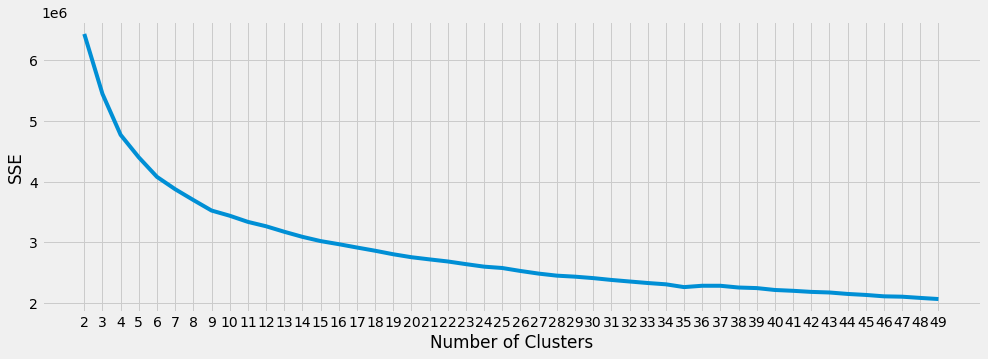

In [45]:
plt.figure(figsize = (15,5))
plt.style.use("fivethirtyeight")
plt.plot(range(2, 50), sse)
plt.xticks(range(2, 50))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [137]:
silhouette_coefficients = []

for k in range(2, 50):
    kmeans = KMeans(n_clusters=k,**kmeans_kwargs)
    kmeans.fit(pca_trasnform)
    score = silhouette_score(pca_trasnform, kmeans.labels_)
    silhouette_coefficients.append(score)


In [47]:
max_score = max(silhouette_coefficients)
min_score = min(silhouette_coefficients)
print('max score: ', max_score)
print('min score: ', min_score)

max score:  0.3124835806438122
min score:  0.16038370701132101


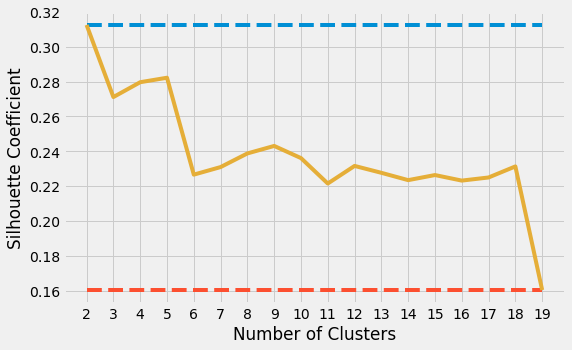

In [114]:
# plotting the above 
y_max = [max_score] * len(silhouette_coefficients)
y_min = [min_score] * len(silhouette_coefficients)

plt.figure(figsize=(8,5))
plt.style.use("fivethirtyeight")
plt.plot(range(2, 20), y_max,linestyle = 'dashed')
plt.plot(range(2, 20), y_min,linestyle = 'dashed')
plt.plot(range(2, 20),silhouette_coefficients )
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [115]:
#comparing silhouette scores for 2 algos

# Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=20)
dbscan = DBSCAN(eps=2.2)

# Fit the algorithms to the features
kmeans.fit(pca_trasnform)
dbscan.fit(pca_trasnform)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(pca_trasnform, kmeans.labels_).round(2)
dbscan_silhouette = silhouette_score(pca_trasnform, dbscan.labels_).round (2)

# comapring the KMeans and DBscan silhouette scores
kmeans_silhouette, dbscan_silhouette

(0.23, -0.28)

In [129]:
kmeans = KMeans(n_clusters=18)
items['cluster'] = kmeans.fit_predict(pca_trasnform)

In [130]:
items.cluster.value_counts()

10    12554
13     3607
6      2726
18     2090
17     1849
2      1843
8      1829
9      1779
7      1767
19     1512
5      1423
3      1308
4      1305
12     1038
0      1016
1       866
16      766
15      754
11      594
14      581
Name: cluster, dtype: int64

<AxesSubplot:xlabel='cluster', ylabel='Count'>

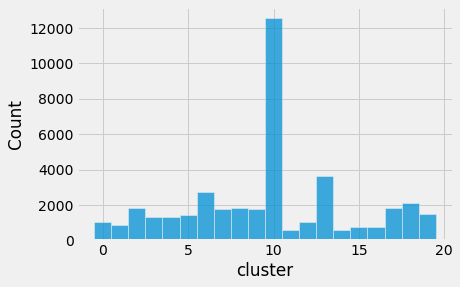

In [140]:
clustered_orders = items[['Id','cluster','Name','tokens']]
sns.histplot(data=clustered_orders, x='cluster', discrete=True)

In [141]:
fpath = '../data'
library.utils.save_file(clustered_orders,'clustered_orders.csv',fpath)

Writing file.  "../data/clustered_orders.csv"


In [132]:
def recommend_clustered_food(item):
    if item in items['Name'].values:
        idx = items[items['Name'] == item].index[0]
        cluster = items.loc[idx]['cluster']
        similar_foods = set(items[items['cluster']== cluster].Name[:10])
        [print(i) for i in similar_foods if i != item]
    else:
        print('item not found')   


In [133]:
names = list(set(items.Name))
sample_name = items[items.Name == random.choice(names)].Name.values[0]
sample_name

'Strike Signature Fried Chicken'

In [134]:
recommend_clustered_food(sample_name)

Chicken Scramble
Chicken Strips And Fries
Chicken Hash-n-eggs
Chicken Pear Sandwich
Clubhouse Wrap
Chicken Caesar Wrap
Chicken And Waffles
Chicken Cucumber Wrap
Grilled Chicken Caesar Wrap
Chicken Burger


In [135]:
food_sam = 'Koobideh Kabob'
recommend_clustered_food(food_sam)

Bitter Ballen
Beef Samosa
Beef Brisket With Chinese Radish Hot Pot
Poutine
Roast Beef Panini
Chinese Fungus With Beef Hot Pot
Satay Beef With Vermicelli Hot Pot
Abc Burger
Beef With Ginger And Onion Hot Pot
Snr Pot Roast Dinner
